In [23]:
%pip install pandas
%pip install scikit-learn
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.interpolate import PchipInterpolator
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error


In [2]:
grandom_state = 69

hq_train_data_path = "./Data/hq_markup_train.csv"
lq_train_data_path = "./Data/markup_train.csv"
submit_path = 'submit1.csv'

In [3]:
hq_train_data = pd.read_csv(hq_train_data_path).sample(frac=1, random_state = grandom_state).reset_index()
lq_train_data = pd.read_csv(lq_train_data_path).sample(frac=1,random_state = grandom_state).reset_index()



In [4]:
validation = pd.read_csv(submit_path)
validation

,file_name,Некачественное ГДИС,Влияние ствола скважины,Радиальный режим,Линейный режим,Билинейный режим,Сферический режим,Граница постоянного давления,Граница непроницаемый разлом,Влияние ствола скважины_details,Радиальный режим_details,Линейный режим_details,Билинейный режим_details,Сферический режим_details,Граница постоянного давления_details,Граница непроницаемый разлом_details
0,283bbcbc-ee90-4a6a-ae06-8392104a2c10,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,cabe112d-93ae-4bb2-9585-a36d3bc31349,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3eaf5015-fe2c-4f54-87c7-cd91142e19f7,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,612e4ad5-98a9-4a53-b034-d14d02305126,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5bf5e5d7-5ad2-49ba-8bcc-719831ad60bc,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,6fe55825-442f-4a73-a659-50346c8096d2,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496,10f9be1f-9ccb-4fa2-ad74-69d53941a6a4,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
497,903787df-01b6-4308-b037-11c7ba81eb4e,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,3c264f8a-df09-4beb-b64f-879c515e88b0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
bin_features = [
    "Некачественное ГДИС",
    "Влияние ствола скважины",
    "Радиальный режим",
    "Линейный режим",
    "Билинейный режим",
    "Сферический режим",
    "Граница постоянного давления",
    "Граница непроницаемый разлом",
]
value_features = [f + "_details" for f in bin_features[1:]]

hq_train_data
# lq_train_data.describe()

,index,file_name,department_name,user_name,Некачественное ГДИС,Влияние ствола скважины,Радиальный режим,Линейный режим,Билинейный режим,Сферический режим,Граница постоянного давления,Граница непроницаемый разлом,Влияние ствола скважины_details,Радиальный режим_details,Линейный режим_details,Билинейный режим_details,Сферический режим_details,Граница постоянного давления_details,Граница непроницаемый разлом_details
0,481,b69a5224-b023-4348-ae94-7f85263b97d1,department2,user4,0,1,1,0,1,0,0,0,1.969838,0.714405,NaN,0.331904,NaN,NaN,NaN
1,130,1b742ac4-ab8b-4eba-b465-8398b3678d8f,department3,user2,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,173,cf0447bd-d3bd-4563-ab53-6a6eb706d5e9,department2,user4,0,1,1,0,0,1,0,0,2.642711,0.587055,NaN,NaN,1.334979,NaN,NaN
3,162,4d4e1792-ff33-476e-bfee-624cf7ba1bc8,department3,user4,1,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,e9c7e07f-b723-4da3-918e-7dbcb360c830,department2,user5,0,1,1,0,0,0,0,1,2.082030,0.109087,NaN,NaN,NaN,NaN,4.647373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,90,e4eb77cf-e20b-4b83-ad73-500399fd2b8d,department2,user14,0,1,1,0,1,0,0,1,1.801439,0.888582,NaN,0.263107,NaN,NaN,661.478022
496,107,1eaadbd3-6a7b-4d53-888c-f0bf6502a888,department3,user4,0,1,0,0,0,1,1,0,1.845751,NaN,NaN,NaN,1.342652,20.901839,NaN
497,457,50a011e9-2a71-4804-b2f4-fba8abb9917f,department2,user5,0,1,1,0,0,0,0,1,2.799587,0.440943,NaN,NaN,NaN,NaN,6.484677
498,203,7b6b0387-68ef-4009-9775-01a93db0339d,department4,user12,0,1,1,0,0,1,1,0,2.164811,-0.864398,NaN,NaN,-0.639542,121.304209,NaN


<Axes: >

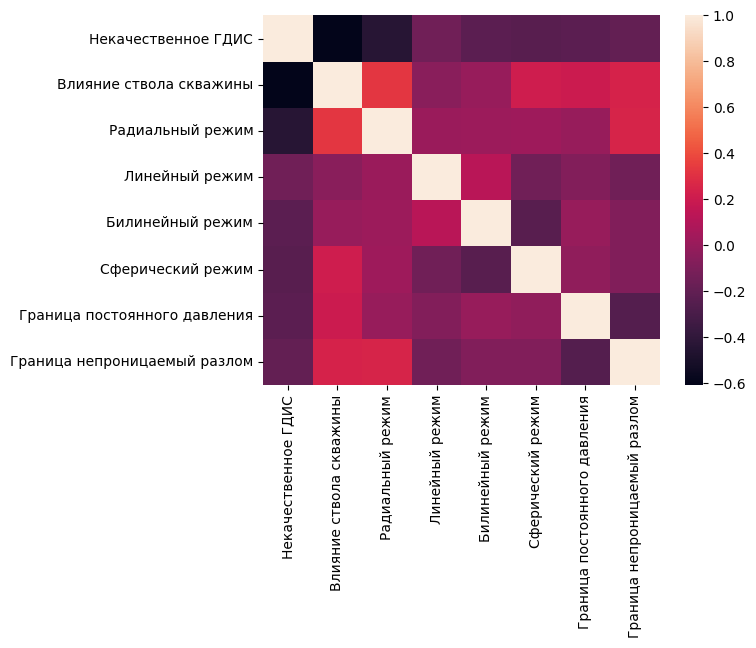

In [6]:
bin_corr = hq_train_data[bin_features].corr()
sns.heatmap(
    bin_corr, xticklabels=bin_corr.columns.values, yticklabels=bin_corr.columns.values
)


<Axes: >

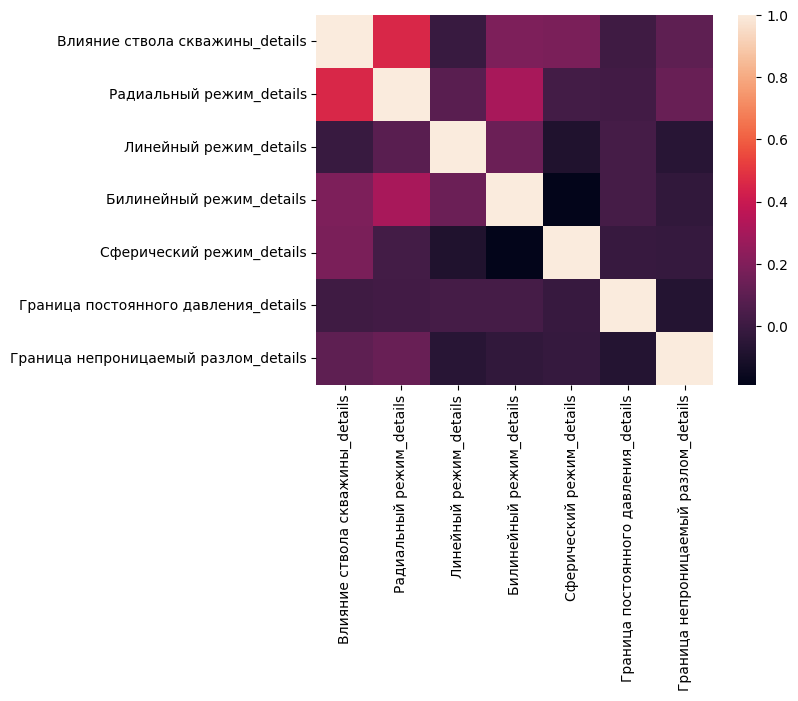

In [7]:
bin_corr = hq_train_data[value_features].fillna(-1).corr()
sns.heatmap(
    bin_corr, xticklabels=bin_corr.columns.values, yticklabels=bin_corr.columns.values
)

In [8]:
def get_series(file_name: str, train=True) -> pd.DataFrame | None:
    """
    Загружает данные из файла с указанным UUID в DataFrame

    Параметры:
    uuid (str): Идентификатор файла
    data_dir (str): Путь к папке с данными (по умолчанию 'data')

    Возвращает:
    pd.DataFrame: DataFrame с колонками ['Time', 'DeltaP', 'P_prime']
    или None если файл не найден
    """
    if train:
        file_path = os.path.join("Data/data", file_name)
    else:
        file_path = os.path.join("Data/validation 1", file_name)
    try:
        df = pd.read_csv(
            file_path,
            sep="\t",
            header=None,
            names=["Time", "DeltaP", "P_prime"],
            dtype={"Time": "float32", "DeltaP": "float32", "P_prime": "float32"},
            engine="c",
        )
        return df
    except FileNotFoundError as x:
        print(file_path)
        print(f"File not found in path:\t {file_path}\n" + x)
        return None


def get_series_from_loc(loc: pd.Series, train=True) -> pd.DataFrame | None:
    return get_series(loc["file_name"], train)


def show_series(s, ax) -> None:
    ax.loglog(s["Time"], s["DeltaP"], "o", markersize=3, color="b", label="Давление")
    ax.loglog(
        s["Time"],
        s["P_prime"],
        "s",
        markersize=3,
        color="g",
        label="Производная давления",
    )
    # ax.set_aspect("equal")
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)


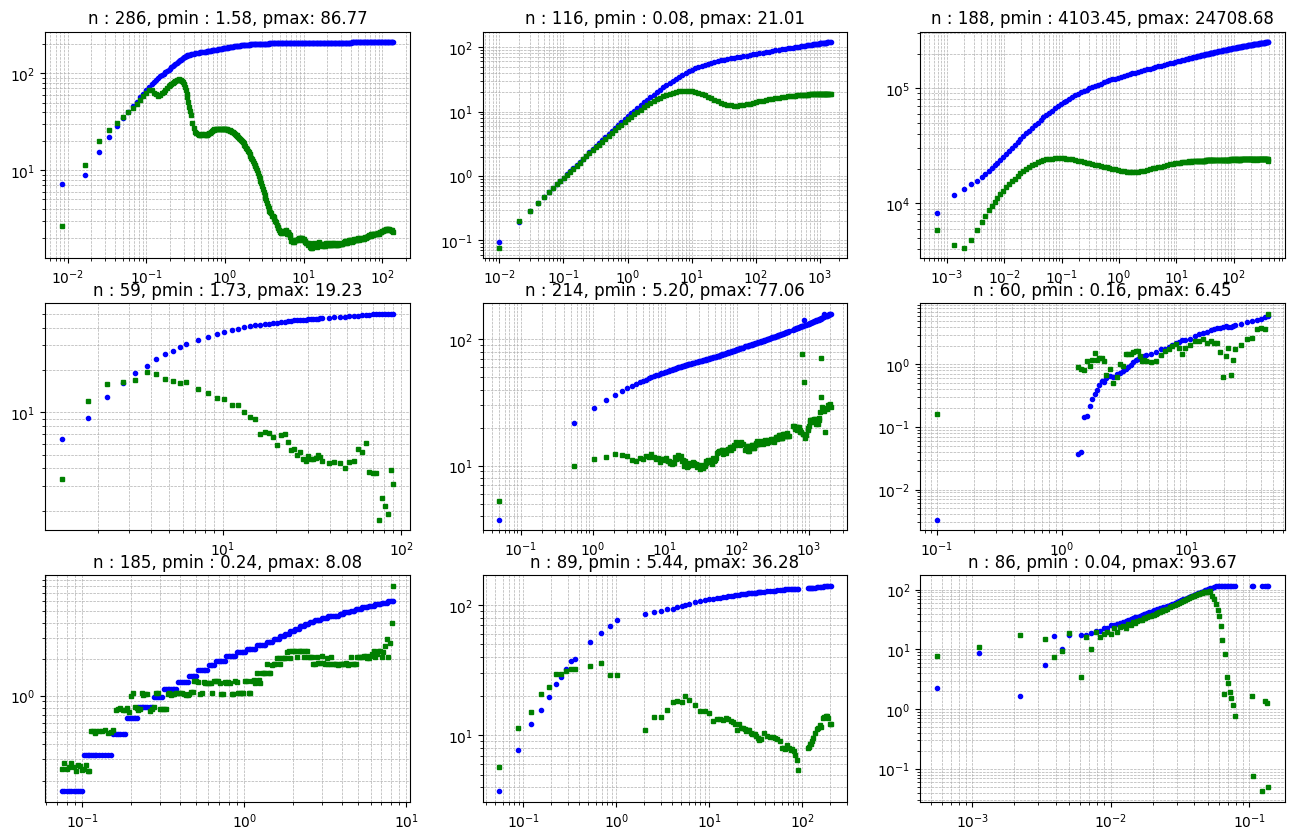

In [9]:
# show some series
size = (3, 3)
random_rows = hq_train_data.sample(n=size[1] * size[0], random_state=grandom_state+1)
fig, ax = plt.subplots(
    *size,
    figsize=(16, 10),
)
for i, v in enumerate(random_rows.iloc):
    x = ax[i // size[0], i % size[1]]
    s = get_series_from_loc(v)
    show_series(s, x)
    x.set_title(
        f"n : {len(s.index)}, pmin : {s['P_prime'].min():.2f}, pmax: {s['P_prime'].max():.2f}"
    )
    # show_series(get_series_from_loc(v), ax)


In [10]:
r = []
for i, v in enumerate(lq_train_data.iloc) :
    s = get_series(v['file_name'])
    if len(s.index) < 2:
        r.append(i)


In [11]:
t = []
for i, v in enumerate(validation.iloc) :
    s = get_series(v['file_name'], False)
    if len(s.index) < 3:
        t.append(i)
dels = t
validationd = validation.drop(t)
for i in t:
    validation.at[i, 'Некачественное ГДИС'] = 1


print(t)

[56, 120, 221, 237]


In [12]:
lq_train_data = lq_train_data.drop(r)

In [13]:
class OilDataset(Dataset):
    def __init__(self, hq_train_data, lq_train_data, get_data_fn=get_series_from_loc):
        super().__init__()
        self.hq_train_data= hq_train_data
        self.lq_train_data= lq_train_data
        self.get_data_fn = get_data_fn
        self.bin_features = [
            "Некачественное ГДИС",
            "Влияние ствола скважины",
            "Радиальный режим",
            "Линейный режим",
            "Билинейный режим",
            "Сферический режим",
            "Граница постоянного давления",
            "Граница непроницаемый разлом",
        ]
        self.value_features = [f + "_details" for f in bin_features[1:]]
        self.series_transform=  None
        self.data_transform= None
        self.hq = True
        self.train = True
    def __len__(self):
        if self.hq:
            return len(self.hq_train_data.index)
        return len(self.lq_train_data.index)
    
    def _series_trainsform(self, s):
    # Интерполяция с сохранением временной оси
        time_original = s['Time'].values
        time_new = np.linspace(time_original.min(), time_original.max(), 512)
        
        # Нормализация времени
        time_scaled = (time_new - time_new.min()) / (time_new.max() - time_new.min() + 1e-8)
        
        # Интерполяция остальных каналов
        delta_p_interp = PchipInterpolator(time_original, s['DeltaP'])(time_new)
        p_prime_interp = PchipInterpolator(time_original, s['P_prime'])(time_new)
        
        # Нормализация данных
        data = np.vstack([
            time_scaled,
            StandardScaler().fit_transform(delta_p_interp.reshape(-1, 1)).flatten(),
            StandardScaler().fit_transform(p_prime_interp.reshape(-1, 1)).flatten()
        ])
        return torch.tensor(data, dtype=torch.float32)  # [3, 512]

    def _data_transform(self, loc):
            # Бинарные признаки
        bin_data = torch.tensor(loc[self.bin_features].values.astype(np.float32)) # [8]
        
        # Числовые детали с учетом порядка режимов
        details = loc[self.value_features].copy()
        
        # Замена NaN и масштабирование с сохранением порядка признаков
        details_filled = details.astype(np.float32).fillna(0).values
        details_scaled = RobustScaler().fit_transform(details_filled.reshape(-1, 1))  # [7]
        
        return (bin_data, torch.tensor(details_scaled, dtype=torch.float32))

    def transform(self, s, d):
        return self._series_trainsform(s), self._data_transform(d)
        

    def __getitem__(self, idx):
        data = self.hq_train_data if self.hq else lq_train_data
        loc = data.iloc[idx]
        return self.transform(get_series_from_loc(loc, self.train), loc)
        

dataset = OilDataset(hq_train_data, lq_train_data)
print((dataset[0][0].size()))

torch.Size([3, 512])


In [14]:
class OilModel(nn.Module):
    def __init__(self, input_size=512, lstm_size=256, num_classes=7):
        super().__init__()
        self.lstm = nn.LSTM(input_size, lstm_size, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_size, 8),
            nn.Sigmoid()
        )
        self.regressor = nn.Sequential(
            nn.Linear(lstm_size, 7)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.mean(dim=1)  # Временное усреднение
        return self.classifier(out), self.regressor(out)

model = OilModel().cuda()

In [15]:
def train_epoch(model=model, loader='', optimizer=torch.optim.Adam(model.parameters()), device='cuda'):
    model.train()
    bin_loss = nn.BCELoss()
    reg_loss = nn.MSELoss()

    for X, (y_bin, y_reg) in loader:
        X, y_bin, y_reg = X.to(device), y_bin.to(device), y_reg.to(device)

        optimizer.zero_grad()
        pred_bin, pred_reg = model(X)
        pred_bin, pred_reg = pred_bin.to(device), pred_reg.to(device)
        y_reg = y_reg.squeeze(-1)

        # Комбинированный loss с маскированием
        loss_cls = bin_loss(pred_bin, y_bin)
        mask = (y_reg != -1).float()
        loss_reg = (reg_loss(pred_reg, y_reg) * mask).mean()
        total_loss = loss_cls + loss_reg
        total_loss.backward()
        optimizer.step()


In [16]:
def validate(model, val_loader, device):
    model.eval()
    bin_preds, bin_true = [], []
    reg_preds, reg_true = [], []

    with torch.no_grad():
        for X, (y_bin, y_reg) in val_loader:
            X = X.to(device)
            p_bin, p_reg = model(X)

            bin_preds.extend(p_bin.cpu().numpy())
            bin_true.extend(y_bin.cpu().numpy())

            mask = y_reg.cpu().numpy() != -1
            reg_preds.extend(p_reg.cpu().numpy()[p_reg.cpu().numpy() != -1
])
            reg_true.extend(y_reg.cpu().numpy()[mask])

    f1 = f1_score(np.round(bin_true), np.round(bin_preds), average="macro")
    mae = mean_absolute_error(reg_true, reg_preds)
    return f1, mae


In [26]:
hq_epoch = 8
hq_opt = torch.optim.Adam(model.parameters(), lr=0.05)
hq_train, hq_valid= torch.utils.data.random_split(dataset, [0.9, 0.1])
hq_train_loader = DataLoader(hq_train, batch_size = 1024)
hq_val_loader = DataLoader(hq_valid, batch_size  = 1024)

for e in range(hq_epoch):
    train_epoch(model, hq_train_loader,hq_opt, 'cuda')
    print(f'{e}:\n')
    print(validate(model, hq_val_loader, 'cuda'))
dataset.hq = False
lq_epoch = 8
lq_train, lq_valid= torch.utils.data.random_split(dataset, [0.9, 0.1])
lq_train_loader = DataLoader(lq_train, batch_size = 1024)
lq_val_loader = DataLoader(lq_valid, batch_size  = 1024)
for e in range(lq_epoch):
    train_epoch(model, lq_train_loader, hq_opt, 'cuda')
    print(f'{e}:\n')
    print(validate(model, lq_val_loader, 'cuda'))


torch.save(model, 'm2.pt')

    

0:

(0.37146582897586133, 17.452842081567535)
1:

(0.3493835464446752, 17.327690537133627)
2:

(0.4239344994798824, 16.866325048815202)
3:

(0.40216878792568467, 17.60448109693974)
4:

(0.4086971527863567, 17.94497443709275)
5:

(0.3905656025154824, 16.971175148220013)
6:

(0.3891708654240429, 17.29911371275828)
7:

(0.4440330815168723, 17.81039720471659)
0:

(0.4132348864218283, 16.462089431868748)
1:

(0.4318571773294095, 18.00184554016073)
2:

(0.4401118640341533, 17.29514072977345)
3:

(0.44193316122403914, 17.41295472242993)
4:

(0.4635518133230395, 17.707904170848902)
5:

(0.4627274677667943, 17.501552825598257)
6:

(0.44338089540282044, 17.24980034397223)
7:

(0.45275851129040434, 18.01132259149441)


In [27]:
def predict(model, test_loader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for X, _ in test_loader:
            X = X.to(device)
            p_bin, p_reg = model(X)
            results.append((p_bin.cpu().numpy(), p_reg.cpu().numpy()))
    return results

In [28]:
vd = OilDataset(validationd, [])
vd.train=False
validation_loader= DataLoader(vd, batch_size = 1)

p = predict(model, validation_loader, 'cuda')


In [29]:
validation

,file_name,Некачественное ГДИС,Влияние ствола скважины,Радиальный режим,Линейный режим,Билинейный режим,Сферический режим,Граница постоянного давления,Граница непроницаемый разлом,Влияние ствола скважины_details,Радиальный режим_details,Линейный режим_details,Билинейный режим_details,Сферический режим_details,Граница постоянного давления_details,Граница непроницаемый разлом_details
0,283bbcbc-ee90-4a6a-ae06-8392104a2c10,0,1,1,0,1,0,0,0,0.012062,0.875371,0.921768,0.424494,0.716093,0.098312,0.064512
1,cabe112d-93ae-4bb2-9585-a36d3bc31349,0,1,0,0,0,0,0,0,0.273962,0.707729,0.246596,0.207129,0.196969,0.059610,0.004781
2,3eaf5015-fe2c-4f54-87c7-cd91142e19f7,0,1,0,0,0,0,0,0,0.145920,0.783080,0.270388,0.415743,0.381047,0.048255,0.006281
3,612e4ad5-98a9-4a53-b034-d14d02305126,0,1,1,0,0,0,1,0,0.125347,0.798992,0.637143,0.182218,0.129006,0.310617,0.584803
4,5bf5e5d7-5ad2-49ba-8bcc-719831ad60bc,0,1,1,0,0,0,0,0,0.132154,0.779890,0.696705,0.079660,0.048142,0.463837,0.282574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,6fe55825-442f-4a73-a659-50346c8096d2,0,1,1,0,0,0,1,0,0.104638,0.766360,0.734377,0.156511,0.131306,0.413163,0.685357
496,10f9be1f-9ccb-4fa2-ad74-69d53941a6a4,0,1,1,0,0,0,0,0,0.082765,0.852483,0.759787,0.062831,0.043795,0.432912,0.133812
497,903787df-01b6-4308-b037-11c7ba81eb4e,0,1,1,0,0,0,1,0,0.094557,0.825516,0.719835,0.210396,0.220855,0.262288,0.606032
498,3c264f8a-df09-4beb-b64f-879c515e88b0,0,1,0,0,0,0,0,0,0.222569,0.762208,0.268576,0.286944,0.251366,0.056858,0.004705


In [30]:
a = 0
for i, v in enumerate(p):
    if i in dels:
        a += 1
    i += a
    for j, r in enumerate(bin_features):
        validation.at[i, r] = 1 if p[i- a][0][0][j] >= 0.5 else 0
    for j, r in enumerate(value_features):
        validation.at[i, r] = p[i-a ][0][0][j]

validation
    

,file_name,Некачественное ГДИС,Влияние ствола скважины,Радиальный режим,Линейный режим,Билинейный режим,Сферический режим,Граница постоянного давления,Граница непроницаемый разлом,Влияние ствола скважины_details,Радиальный режим_details,Линейный режим_details,Билинейный режим_details,Сферический режим_details,Граница постоянного давления_details,Граница непроницаемый разлом_details
0,283bbcbc-ee90-4a6a-ae06-8392104a2c10,0,1,1,1,1,0,0,0,0.039908,0.708489,0.905204,0.503321,0.623905,0.027439,0.008545
1,cabe112d-93ae-4bb2-9585-a36d3bc31349,0,1,1,0,0,0,0,0,0.220231,0.820341,0.540181,0.224065,0.132759,0.219099,0.014314
2,3eaf5015-fe2c-4f54-87c7-cd91142e19f7,0,1,0,0,0,0,0,0,0.083036,0.805477,0.425521,0.489749,0.331938,0.136036,0.005156
3,612e4ad5-98a9-4a53-b034-d14d02305126,0,1,0,0,0,0,1,0,0.102046,0.910415,0.323501,0.184675,0.049826,0.345059,0.780005
4,5bf5e5d7-5ad2-49ba-8bcc-719831ad60bc,0,1,1,0,0,1,0,0,0.059802,0.867891,0.766952,0.071989,0.049300,0.532106,0.320246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,6fe55825-442f-4a73-a659-50346c8096d2,0,1,0,0,0,0,0,0,0.274784,0.768073,0.262731,0.094176,0.027603,0.271190,0.326050
496,10f9be1f-9ccb-4fa2-ad74-69d53941a6a4,0,1,1,0,0,0,0,0,0.140478,0.856779,0.775541,0.067854,0.034909,0.217192,0.059272
497,903787df-01b6-4308-b037-11c7ba81eb4e,0,1,1,0,0,0,1,0,0.059163,0.891679,0.766951,0.164229,0.161875,0.288670,0.617645
498,3c264f8a-df09-4beb-b64f-879c515e88b0,0,1,1,0,0,0,0,0,0.167000,0.838606,0.546832,0.277255,0.223119,0.193732,0.008315


In [31]:
validation.to_csv('ansver1.csv')